<a href="https://colab.research.google.com/github/pranshudiwan/NLP_CS_6200/blob/main/NLP_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Sindhu Baseline LSTM

##Importing Libraries

In [339]:
#@title
# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import wordcloud
!pip install pyspellchecker
from spellchecker import SpellChecker
import math, os, re, time, random, string

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from tqdm import tqdm
from collections import defaultdict
import tensorflow as tf

# Keras imports
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Bidirectional, Dropout, Concatenate, LeakyReLU, GRU
from keras import Input, Model, regularizers
from keras.optimizers import Adam
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.preprocessing.sequence import pad_sequences
from keras import Input
from keras.preprocessing.text import Tokenizer

from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [340]:
#@title
def seed_everything(seed):
    os.environ['PYTHONHASHSEED']=str(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    
seed_everything(34)

## Downloading Glove words vectors files

In [241]:
#@title
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

--2021-04-29 21:23:14--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-04-29 21:23:14--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-04-29 21:23:14--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.4’

glove

##Importing train and test data

In [341]:
#@title
# Import train data
url_train = 'https://raw.githubusercontent.com/pranshudiwan/NLP_CS_6200/main/train.csv'
train = pd.read_csv(url_train)

# Import est data
url_test = 'https://raw.githubusercontent.com/pranshudiwan/NLP_CS_6200/main/test.csv'
test   = pd.read_csv(url_test)

##Single DataFrame

In [342]:
#@title
train = train.drop(columns = {'id', 'location', 'keyword'})
test = test.drop(columns = {'id', 'location', 'keyword'})
combined = train.append(test)

## Visualization
- Class Distribution (number of tweets in each class)
- Number of characters in tweets
- Number of words in tweets
- Average length of word in a tweet

0.0    4342
1.0    3271
Name: target, dtype: int64 



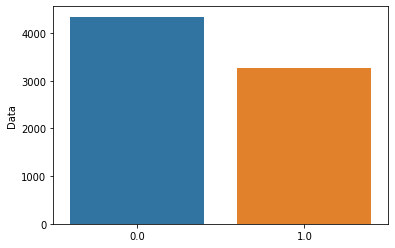

In [307]:
#@title
# Class distribution
class_counts=combined.target.value_counts()
sns.barplot(x=class_counts.index,y=class_counts)
plt.gca().set_ylabel('Data')
print(class_counts , "\n")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


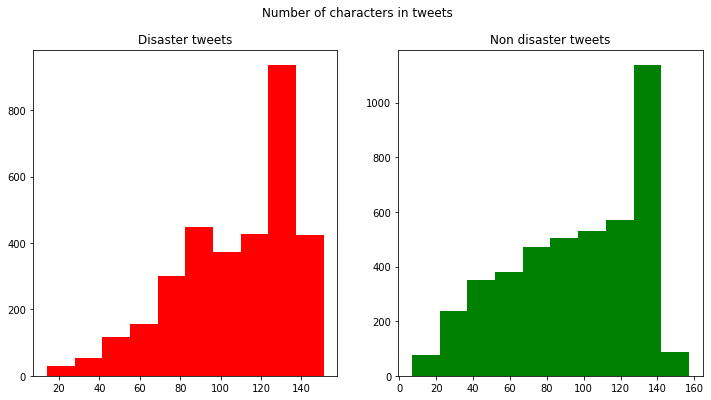

In [308]:
#@title
# Number of characters in tweets
train = combined[:len(train)]
train['character_count'] = train['text'].apply(lambda word: len(word))

# For Disaster tweets
disaster_tweet_len=train[train['target']==1]['character_count']
#print(disaster_tweet_len)
non_disaster_tweet_len=train[train['target']==0]['character_count']
#print(non_disaster_tweet_len)

# plotting
plot,(subplot1,subplot2)=plt.subplots(1,2,figsize=(12,6))
subplot1.hist(disaster_tweet_len,color='red')
subplot1.set_title('Disaster tweets')
subplot2.hist(non_disaster_tweet_len,color='green')
subplot2.set_title('Non disaster tweets')
plot.suptitle('Number of characters in tweets')
plt.show()

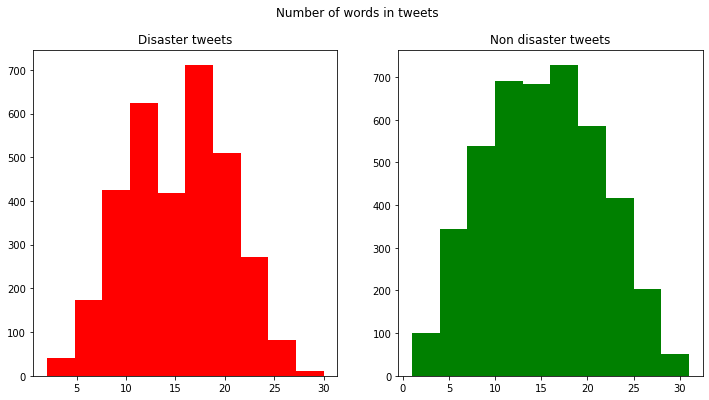

In [309]:
#@title
# Number of words in tweets
# For Disaster tweets
disaster_no_of_words=train[train['target']==1]['text'].str.split().map(lambda tweet : len(tweet))
#print(disaster_no_of_words)
non_disaster_no_of_words=train[train['target']==0]['text'].str.split().map(lambda tweet : len(tweet))
#print(non_disaster_no_of_words)


# Plotting number of words
plot,(subplot1,subplot2)=plt.subplots(1,2,figsize=(12,6))
subplot1.hist(disaster_no_of_words,color='red')
subplot1.set_title('Disaster tweets')
subplot2.hist(non_disaster_no_of_words,color='green')
subplot2.set_title('Non disaster tweets')
plot.suptitle('Number of words in tweets')
plt.show()

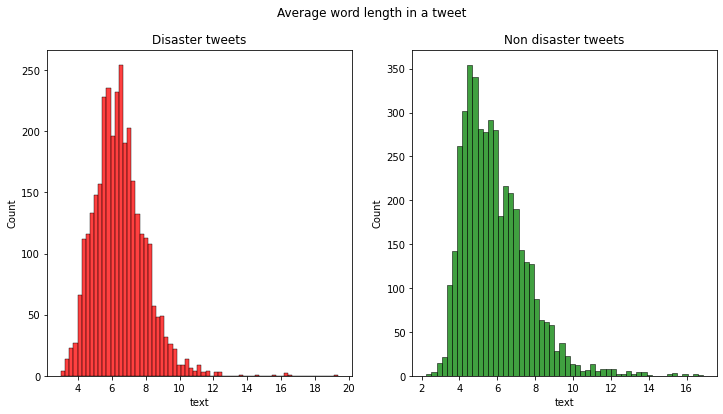

In [310]:
#@title
# For Disaster tweets
disaster_word_len=train[train['target']==1]['text'].str.split().apply(lambda tweet : [len(word) for word in tweet])
# print(disaster_word_len)
#print('Average word length of disaster tweets', disaster_word_len.map(lambda word_len: np.mean(word_len)))
non_disaster_word_len=train[train['target']==0]['text'].str.split().apply(lambda tweet : [len(word) for word in tweet])
# print(non_disaster_word_len)
#print('Average word length of non disaster tweets', non_disaster_word_len.map(lambda word_len: np.mean(word_len)))

# Plotting number of words
plot,(subplot1,subplot2)=plt.subplots(1,2,figsize=(12,6))
sns.histplot(disaster_word_len.map(lambda word_len: np.mean(word_len)),ax=subplot1,color='red')
subplot1.set_title('Disaster tweets')

sns.histplot(non_disaster_word_len.map(lambda word_len: np.mean(word_len)),ax=subplot2,color='green')
subplot2.set_title('Non disaster tweets')
plot.suptitle('Average word length in a tweet')
plt.show()

## Data Cleaning for LSTM
- Remove punctuation
- Remove stopwords
- Remove non alphabets
- Remove emojis
- Spellcheck each word
- Expanding all slangs, acronyms and abbreviations
- stemming of texts

In [286]:
#@title
def remove_punctuation(tweets):
    return tweets.translate(str.maketrans('', '', string.punctuation))

In [287]:
#@title
def remove_stopwords(tweets):
    return ' '.join([word for word in tweets.split() if word not in wordcloud.STOPWORDS]) # using wordcloud stopwords instead of nltk stopwords

In [288]:
#@title
def remove_non_alphabet(tweets):
    return ' '.join([word for word in tweets.split() if word.isalpha()])

In [289]:
#@title
spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

In [290]:
#@title
def remove_emoji(tweets):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', tweets)

In [266]:
#@title
def expand_slang_abbr_acronyms(tweets):
        """
            Other manual text cleaning techniques
        """
        # Typos, slang and other
        sample_typos_slang = {
                                "w/e": "whatever",
                                "usagov": "usa government",
                                "recentlu": "recently",
                                "ph0tos": "photos",
                                "amirite": "am i right",
                                "exp0sed": "exposed",
                                "<3": "love",
                                "luv": "love",
                                "amageddon": "armageddon",
                                "trfc": "traffic",
                                "16yr": "16 year"
                                }

        # Acronyms
        sample_acronyms =  { 
                            "mh370": "malaysia airlines flight 370",
                            "okwx": "oklahoma city weather",
                            "arwx": "arkansas weather",    
                            "gawx": "georgia weather",  
                            "scwx": "south carolina weather",  
                            "cawx": "california weather",
                            "tnwx": "tennessee weather",
                            "azwx": "arizona weather",  
                            "alwx": "alabama weather",
                            "usnwsgov": "united states national weather service",
                            "2mw": "tomorrow"
                            }

        
        # Some common abbreviations 
        sample_abbr = {
                        "$" : " dollar ",
                        "€" : " euro ",
                        "4ao" : "for adults only",
                        "a.m" : "before midday",
                        "a3" : "anytime anywhere anyplace",
                        "aamof" : "as a matter of fact",
                        "acct" : "account",
                        "adih" : "another day in hell",
                        "afaic" : "as far as i am concerned",
                        "afaict" : "as far as i can tell",
                        "afaik" : "as far as i know",
                        "afair" : "as far as i remember",
                        "afk" : "away from keyboard",
                        "app" : "application",
                        "approx" : "approximately",
                        "apps" : "applications",
                        "asap" : "as soon as possible",
                        "asl" : "age, sex, location",
                        "atk" : "at the keyboard",
                        "ave." : "avenue",
                        "aymm" : "are you my mother",
                        "ayor" : "at your own risk", 
                        "b&b" : "bed and breakfast",
                        "b+b" : "bed and breakfast",
                        "b.c" : "before christ",
                        "b2b" : "business to business",
                        "b2c" : "business to customer",
                        "b4" : "before",
                        "b4n" : "bye for now",
                        "b@u" : "back at you",
                        "bae" : "before anyone else",
                        "bak" : "back at keyboard",
                        "bbbg" : "bye bye be good",
                        "bbc" : "british broadcasting corporation",
                        "bbias" : "be back in a second",
                        "bbl" : "be back later",
                        "bbs" : "be back soon",
                        "be4" : "before",
                        "bfn" : "bye for now",
                        "blvd" : "boulevard",
                        "bout" : "about",
                        "brb" : "be right back",
                        "bros" : "brothers",
                        "brt" : "be right there",
                        "bsaaw" : "big smile and a wink",
                        "btw" : "by the way",
                        "bwl" : "bursting with laughter",
                        "c/o" : "care of",
                        "cet" : "central european time",
                        "cf" : "compare",
                        "cia" : "central intelligence agency",
                        "csl" : "can not stop laughing",
                        "cu" : "see you",
                        "cul8r" : "see you later",
                        "cv" : "curriculum vitae",
                        "cwot" : "complete waste of time",
                        "cya" : "see you",
                        "cyt" : "see you tomorrow",
                        "dae" : "does anyone else",
                        "dbmib" : "do not bother me i am busy",
                        "diy" : "do it yourself",
                        "dm" : "direct message",
                        "dwh" : "during work hours",
                        "e123" : "easy as one two three",
                        "eet" : "eastern european time",
                        "eg" : "example",
                        "embm" : "early morning business meeting",
                        "encl" : "enclosed",
                        "encl." : "enclosed",
                        "etc" : "and so on",
                        "faq" : "frequently asked questions",
                        "fawc" : "for anyone who cares",
                        "fb" : "facebook",
                        "fc" : "fingers crossed",
                        "fig" : "figure",
                        "fimh" : "forever in my heart", 
                        "ft." : "feet",
                        "ft" : "featuring",
                        "ftl" : "for the loss",
                        "ftw" : "for the win",
                        "fwiw" : "for what it is worth",
                        "fyi" : "for your information",
                        "g9" : "genius",
                        "gahoy" : "get a hold of yourself",
                        "gal" : "get a life",
                        "gcse" : "general certificate of secondary education",
                        "gfn" : "gone for now",
                        "gg" : "good game",
                        "gl" : "good luck",
                        "glhf" : "good luck have fun",
                        "gmt" : "greenwich mean time",
                        "gmta" : "great minds think alike",
                        "gn" : "good night",
                        "g.o.a.t" : "greatest of all time",
                        "goat" : "greatest of all time",
                        "goi" : "get over it",
                        "gps" : "global positioning system",
                        "gr8" : "great",
                        "gratz" : "congratulations",
                        "gyal" : "girl",
                        "h&c" : "hot and cold",
                        "hp" : "horsepower",
                        "hr" : "hour",
                        "hrh" : "his royal highness",
                        "ht" : "height",
                        "ibrb" : "i will be right back",
                        "ic" : "i see",
                        "icq" : "i seek you",
                        "icymi" : "in case you missed it",
                        "idc" : "i do not care",
                        "idgadf" : "i do not give a damn fuck",
                        "idgaf" : "i do not give a fuck",
                        "idk" : "i do not know",
                        "ie" : "that is",
                        "i.e" : "that is",
                        "ifyp" : "i feel your pain",
                        "IG" : "instagram",
                        "iirc" : "if i remember correctly",
                        "ilu" : "i love you",
                        "ily" : "i love you",
                        "imho" : "in my humble opinion",
                        "imo" : "in my opinion",
                        "imu" : "i miss you",
                        "iow" : "in other words",
                        "irl" : "in real life",
                        "j4f" : "just for fun",
                        "jic" : "just in case",
                        "jk" : "just kidding",
                        "jsyk" : "just so you know",
                        "l8r" : "later",
                        "lb" : "pound",
                        "lbs" : "pounds",
                        "ldr" : "long distance relationship",
                        "lmao" : "laugh my ass off",
                        "lmfao" : "laugh my fucking ass off",
                        "lol" : "laughing out loud",
                        "ltd" : "limited",
                        "ltns" : "long time no see",
                        "m8" : "mate",
                        "mf" : "motherfucker",
                        "mfs" : "motherfuckers",
                        "mfw" : "my face when",
                        "mofo" : "motherfucker",
                        "mph" : "miles per hour",
                        "mr" : "mister",
                        "mrw" : "my reaction when",
                        "ms" : "miss",
                        "mte" : "my thoughts exactly",
                        "nagi" : "not a good idea",
                        "nbc" : "national broadcasting company",
                        "nbd" : "not big deal",
                        "nfs" : "not for sale",
                        "ngl" : "not going to lie",
                        "nhs" : "national health service",
                        "nrn" : "no reply necessary",
                        "nsfl" : "not safe for life",
                        "nsfw" : "not safe for work",
                        "nth" : "nice to have",
                        "nvr" : "never",
                        "nyc" : "new york city",
                        "oc" : "original content",
                        "og" : "original",
                        "ohp" : "overhead projector",
                        "oic" : "oh i see",
                        "omdb" : "over my dead body",
                        "omg" : "oh my god",
                        "omw" : "on my way",
                        "p.a" : "per annum",
                        "p.m" : "after midday",
                        "pm" : "prime minister",
                        "poc" : "people of color",
                        "pov" : "point of view",
                        "pp" : "pages",
                        "ppl" : "people",
                        "prw" : "parents are watching",
                        "ps" : "postscript",
                        "pt" : "point",
                        "ptb" : "please text back",
                        "pto" : "please turn over",
                        "qpsa" : "what happens", #"que pasa",
                        "ratchet" : "rude",
                        "rbtl" : "read between the lines",
                        "rlrt" : "real life retweet", 
                        "rofl" : "rolling on the floor laughing",
                        "roflol" : "rolling on the floor laughing out loud",
                        "rotflmao" : "rolling on the floor laughing my ass off",
                        "rt" : "retweet",
                        "ruok" : "are you ok",
                        "sfw" : "safe for work",
                        "sk8" : "skate",
                        "smh" : "shake my head",
                        "sq" : "square",
                        "srsly" : "seriously", 
                        "ssdd" : "same stuff different day",
                        "tbh" : "to be honest",
                        "tbs" : "tablespooful",
                        "tbsp" : "tablespooful",
                        "tfw" : "that feeling when",
                        "thks" : "thank you",
                        "tho" : "though",
                        "thx" : "thank you",
                        "tia" : "thanks in advance",
                        "til" : "today i learned",
                        "tl;dr" : "too long i did not read",
                        "tldr" : "too long i did not read",
                        "tmb" : "tweet me back",
                        "tntl" : "trying not to laugh",
                        "ttyl" : "talk to you later",
                        "u" : "you",
                        "u2" : "you too",
                        "u4e" : "yours for ever",
                        "utc" : "coordinated universal time",
                        "w/" : "with",
                        "w/o" : "without",
                        "w8" : "wait",
                        "wassup" : "what is up",
                        "wb" : "welcome back",
                        "wtf" : "what the fuck",
                        "wtg" : "way to go",
                        "wtpa" : "where the party at",
                        "wuf" : "where are you from",
                        "wuzup" : "what is up",
                        "wywh" : "wish you were here",
                        "yd" : "yard",
                        "ygtr" : "you got that right",
                        "ynk" : "you never know",
                        "zzz" : "sleeping bored and tired"
                        }
            
        sample_typos_slang_pattern = re.compile(r'(?<!\w)(' + '|'.join(re.escape(key) for key in sample_typos_slang.keys()) + r')(?!\w)')
        sample_acronyms_pattern = re.compile(r'(?<!\w)(' + '|'.join(re.escape(key) for key in sample_acronyms.keys()) + r')(?!\w)')
        sample_abbr_pattern = re.compile(r'(?<!\w)(' + '|'.join(re.escape(key) for key in sample_abbr.keys()) + r')(?!\w)')
        
        tweets = sample_typos_slang_pattern.sub(lambda x: sample_typos_slang[x.group()], tweets)
        tweets = sample_acronyms_pattern.sub(lambda x: sample_acronyms[x.group()], tweets)
        tweets = sample_abbr_pattern.sub(lambda x: sample_abbr[x.group()], tweets)
        
        return tweets

In [291]:
def stem(unstemmed_list):  
  ps = PorterStemmer()

  final_stemmed_list = []

  for i in range(len(unstemmed_list)):
    sentence = unstemmed_list[i]
    #print(sentence)
    words = word_tokenize(sentence)
    stemmed_list = []
    for w in words:
        stemmed_list.append(ps.stem(w))
    stemmed_list = ' '.join(stemmed_list)
    final_stemmed_list.append(stemmed_list)

  return final_stemmed_list

In [292]:
#@title

#making the string lower case
unstemmed_list = combined['text'].tolist()
combined['text'] = stem(unstemmed_list)
combined['text'] = combined['text'].str.replace('\d+', '')

In [293]:
#@title
# CLEAN DATA 

combined['text'] = combined['text'].apply(lambda x: x.lower())
combined['text'] = combined['text'].apply(remove_punctuation)
combined['text'] = combined['text'].apply(remove_stopwords)
combined['text'] = combined['text'].apply(remove_non_alphabet)
#combined['text'] = combined['text'].apply(correct_spellings)
combined['text'] = combined['text'].apply(lambda x: remove_emoji(x))
combined["text"] = combined["text"].apply(lambda x: expand_slang_abbr_acronyms(x))

combined.sample(10)

,text,target
5379,sav contact fell wa convinc didnt amp went gua...,0.0
1195,obama declar disast typhoondevast saipan obama...,NaN
4206,prime minister hazard high traffic area dean b...,1.0
3945,w cree led work light bar alloy spot flood com...,0.0
5822,china s stock market crash gem rubbl tcopbfyjxya,0.0
2262,nsw bankstown stacey st wattl st hazard oil sp...,NaN
3812,join chariti run event doningtondash start sun...,0.0
3234,scienc now piec wreckag flight mh ha confirm i...,NaN
2439,madhya pradesh train derail villag youth save ...,1.0
6868,role usg pa major trauma imag decis tool foam ...,0.0


## Simple LSTM


In [343]:
tweets = [tweet for tweet in combined['text']]
train = combined[:len(train)]
test = combined[len(train):]

In [344]:
tokenizer = Tokenizer()     
tokenizer.fit_on_texts(tweets)
sequences = tokenizer.texts_to_sequences(tweets)
word_index = tokenizer.word_index
pad_sequences = pad_sequences(sequences)
labels = train['target']
model_train = pad_sequences[:len(train)]
model_test = pad_sequences[len(train):]
MAX_SEQUENCE_LENGTH = pad_sequences.shape[1]

In [345]:
embeddings_map = {}
with open('glove.6B.200d.txt','r') as f: # choosing 6B variant with 200 dimensions
    for li in tqdm(f):
        vals = li.split()
        word = vals[0]
        cofs = np.asarray(vals[1:], dtype='float32')
        embeddings_map[word] = cofs
f.close()

400000it [00:22, 17488.80it/s]


In [346]:
embedding_matrix = np.zeros((len(word_index) + 1, 200))
for word, i in tqdm(word_index.items()):
    vector = embeddings_map.get(word)
    if vector is not None:        
        embedding_matrix[i] = vector

100%|██████████| 29319/29319 [00:00<00:00, 438363.51it/s]


In [347]:
embedding = Embedding(len(word_index) + 1, 200, weights = [embedding_matrix], input_length = MAX_SEQUENCE_LENGTH, trainable = False)

In [348]:
# referenced from stack overflow
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [349]:
def lstm_model(dropout, recurrent_dropout, learning_rate):
    input = Input(shape = (MAX_SEQUENCE_LENGTH,), name = 'input')
    embed = embedding(input)
    
    out = (LSTM(100, dropout = dropout, recurrent_dropout = recurrent_dropout, kernel_initializer = 'orthogonal'))(embed)        
    
    activation_function = LeakyReLU(alpha = 0.01)
    dense_layer = Dense(1, activation=activation_function, kernel_regularizer = regularizers.l2(1e-4))(out)
    
    optimizer = Adam(learning_rate = learning_rate)
    model = Model(inputs=input, outputs = dense_layer)
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy', f1_m, precision_m, recall_m])
    
    return model

In [350]:
model = lstm_model(dropout = 0.2, recurrent_dropout = 0.2, learning_rate = 3e-4)
model.summary()

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 33)]              0         
_________________________________________________________________
embedding_13 (Embedding)     (None, 33, 200)           5864000   
_________________________________________________________________
lstm_15 (LSTM)               (None, 100)               120400    
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 101       
Total params: 5,984,501
Trainable params: 120,501
Non-trainable params: 5,864,000
_________________________________________________________________


In [352]:
his = model.fit([model_train], labels, validation_split = .2, epochs = 5, batch_size = 21, verbose = 1)

Epoch 1/5
290/290 [==============================] - 20s 68ms/step - loss: 0.5702 - accuracy: 0.7297 - f1_m: 0.6538 - precision_m: 0.6887 - recall_m: 0.6472 - val_loss: 0.5672 - val_accuracy: 0.7531 - val_f1_m: 0.5791 - val_precision_m: 0.6200 - val_recall_m: 0.5703
Epoch 2/5
290/290 [==============================] - 20s 68ms/step - loss: 0.5541 - accuracy: 0.7468 - f1_m: 0.6682 - precision_m: 0.7320 - recall_m: 0.6410 - val_loss: 0.5447 - val_accuracy: 0.7630 - val_f1_m: 0.5875 - val_precision_m: 0.6426 - val_recall_m: 0.5752
Epoch 3/5
290/290 [==============================] - 20s 68ms/step - loss: 0.5303 - accuracy: 0.7539 - f1_m: 0.6888 - precision_m: 0.7201 - recall_m: 0.6875 - val_loss: 0.5321 - val_accuracy: 0.7682 - val_f1_m: 0.6148 - val_precision_m: 0.6320 - val_recall_m: 0.6253
Epoch 4/5
290/290 [==============================] - 20s 68ms/step - loss: 0.5180 - accuracy: 0.7681 - f1_m: 0.6832 - precision_m: 0.7616 - recall_m: 0.6442 - val_loss: 0.5144 - val_accuracy: 0.7794 